In [ ]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.2 MB/s eta 0:00:00


In [ ]:
dataset_path = "/content/drive/MyDrive/Ravdess/ravdess/audio_speech_actors_01-24"

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from IPython.display import display, Audio

import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = []
emotions = []

dirs = os.listdir(dataset_path)
for dir in dirs :
  fname = os.listdir(os.path.join(dataset_path, dir))
  for f in fname :
    path.append(os.path.join(dataset_path, dir, f))
    emotions.append(int(f.split('.')[0].split('-')[2]))

In [ ]:
print(path[2:6] ,'\n', emotions[2:6])

['/content/drive/MyDrive/Ravdess/ravdess/audio_speech_actors_01-24/Actor_24/03-01-02-01-01-01-24.wav', '/content/drive/MyDrive/Ravdess/ravdess/audio_speech_actors_01-24/Actor_24/03-01-06-02-02-01-24.wav', '/content/drive/MyDrive/Ravdess/ravdess/audio_speech_actors_01-24/Actor_24/03-01-05-01-02-02-24.wav', '/content/drive/MyDrive/Ravdess/ravdess/audio_speech_actors_01-24/Actor_24/03-01-04-02-02-01-24.wav'] 
 [2, 6, 5, 4]


In [ ]:
df = pd.DataFrame({'path' : path, 'emotion' : emotions})
df.head()

,path,emotion
0,/content/drive/MyDrive/Ravdess/ravdess/audio_s...,2
1,/content/drive/MyDrive/Ravdess/ravdess/audio_s...,6
2,/content/drive/MyDrive/Ravdess/ravdess/audio_s...,2
3,/content/drive/MyDrive/Ravdess/ravdess/audio_s...,6
4,/content/drive/MyDrive/Ravdess/ravdess/audio_s...,5


In [ ]:
df.shape

(1440, 2)

In [ ]:
df['emotion'] = df['emotion'].replace({1 : 'neutral', 2 : 'calm', 3 : 'happy', 4 : 'sad', 5 : 'angry', 6 : 'fear', 7 : 'disgust', 8 : 'surprise'})
df.tail()

,path,emotion
1435,/content/drive/MyDrive/Ravdess/ravdess/audio_s...,sad
1436,/content/drive/MyDrive/Ravdess/ravdess/audio_s...,disgust
1437,/content/drive/MyDrive/Ravdess/ravdess/audio_s...,sad
1438,/content/drive/MyDrive/Ravdess/ravdess/audio_s...,surprise
1439,/content/drive/MyDrive/Ravdess/ravdess/audio_s...,angry


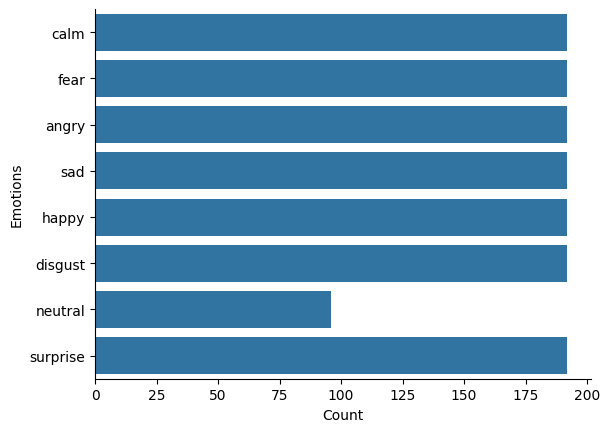

In [ ]:
sns.countplot(df['emotion'])
plt.xlabel('Count')
plt.ylabel('Emotions')
sns.despine(top = True, right = True)
plt.show()

In [ ]:
def waveplot(data, sr, e) :
  plt.figure(figsize = (10, 3))
  plt.title(f'Waveplot for {e}', size = 15)
  librosa.display.waveshow(data, sr = sr)
  plt.show()

In [ ]:
def spectrogram(data, sr, e) :
  plt.figure(figsize=(10,3))
  stft = librosa.stft(data)
  xdb = librosa.amplitude_to_db(abs(stft))
  plt.title(f'Spectrogram for {e}', size = 15)
  librosa.display.specshow(xdb, sr=sr, x_axis = 'time', y_axis = 'hz')
  plt.colorbar()
  plt.show()

In [ ]:
pt = np.array((df[df['emotion'] == 'fear']['path']))
fp = pt[1]
arr, sr = librosa.load(fp)

In [ ]:
arr

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        1.5329544e-05, -3.7290013e-06,  0.0000000e+00], dtype=float32)

In [ ]:
sr

22050

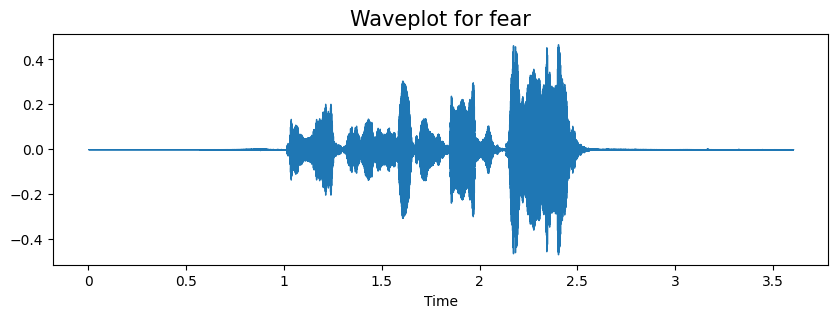

In [ ]:
waveplot(arr, sr, 'fear')

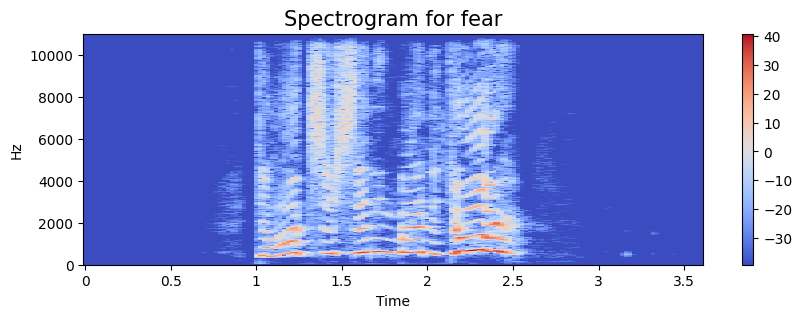

In [ ]:
spectrogram(arr, sr, 'fear')

In [ ]:
Audio(fp)

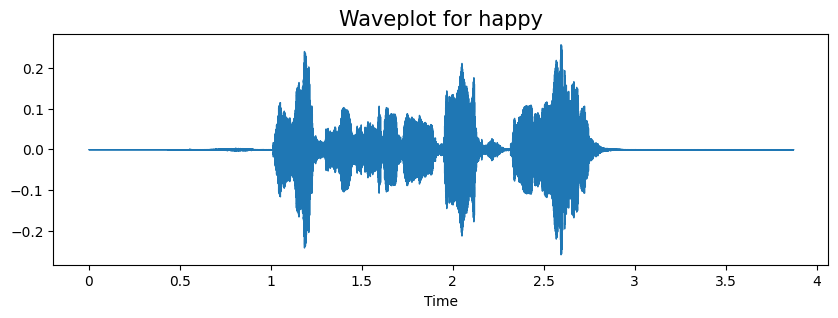

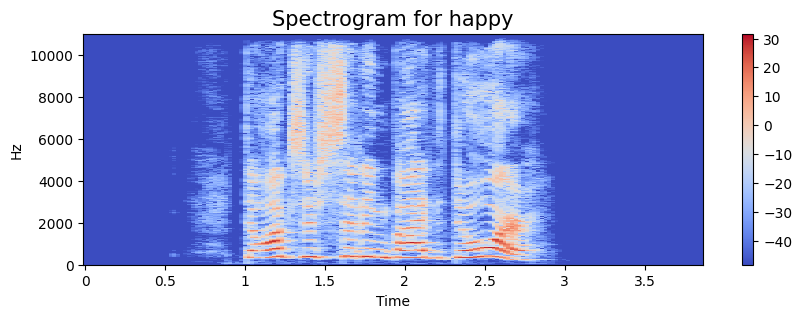

In [ ]:
pt = np.array((df[df['emotion'] == 'happy']['path']))
fp = pt[1]
arr, sr = librosa.load(fp)
waveplot(arr, sr, 'happy')
spectrogram(arr, sr, 'happy')

In [ ]:
import resampy

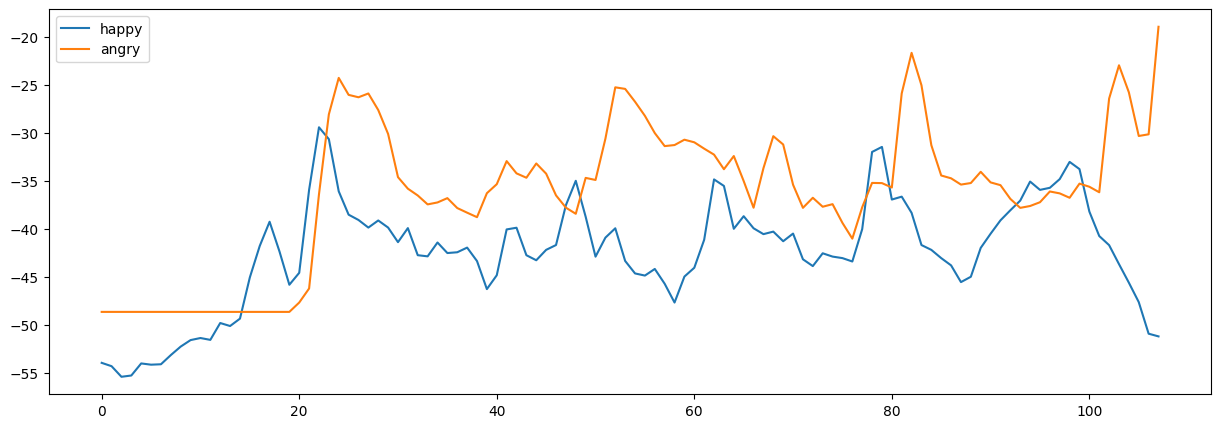

In [ ]:
pt = np.array((df[df['emotion'] == 'happy']['path']))
hp = pt[1]
arr, sr = librosa.load(hp, offset=0.5, sr=22050, duration=2.5)  # res_type = 'kaiser_fast'
mfcc = librosa.feature.mfcc(y=arr, sr=sr, n_mfcc=13)
happy = np.mean(mfcc, axis=0)

pt = np.array((df[df['emotion'] == 'angry']['path']))
ap = pt[1]
arr, sr = librosa.load(ap, offset = 0.5, sr = 22050, duration=2.5)   # res_type = 'kaiser_fast'
mfcc = librosa.feature.mfcc(y=arr, sr=sr, n_mfcc=13)
angry = np.mean(mfcc, axis = 0)

plt.figure(figsize = (15,5))
plt.plot(happy, label = 'happy')
plt.plot(angry, label = 'angry')
plt.legend()
plt.show()

In [ ]:
# data augmentation
def noise(data) :
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  noised = data + noise_amp*np.random.normal(size = data.shape[0])
  return noised

def stretch(data, rate = 0.8) :
  return librosa.effects.time_stretch(data, rate = rate)

def pitch(data, sr, rate = 0.7, n_steps=None) :
  return librosa.effects.pitch_shift(data, sr = sr, n_steps = rate)

def shift(data) :
  range = int(np.random.uniform(low = -5, high = 5)*10)
  return np.roll(data, range)

In [ ]:
path = df['path'][1]
data, sr = librosa.load(path)

In [ ]:
noised_data = noise(data)
stretch_data = stretch(data)
pitch_data = pitch(data, sr, n_steps=4)
shift_data = shift(data)

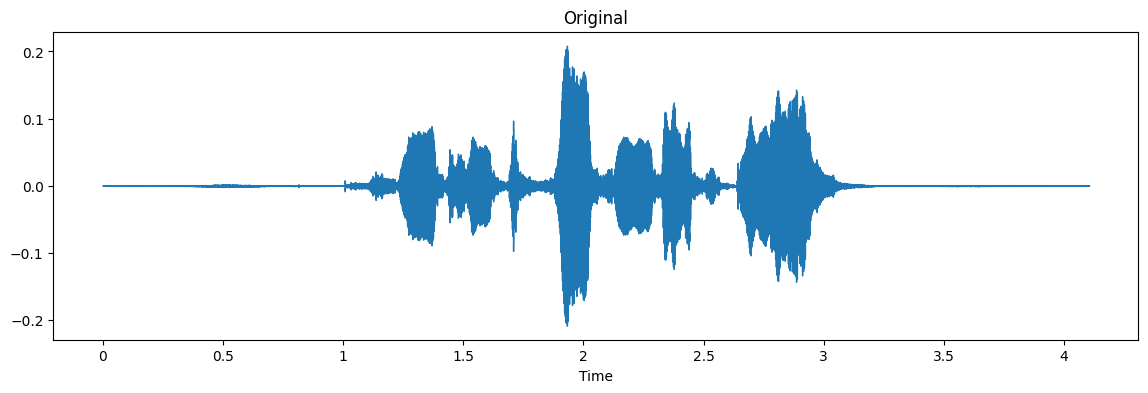

In [ ]:
plt.figure(figsize = (14,4))
librosa.display.waveshow(data, sr = sr)
plt.title('Original')
Audio(path)

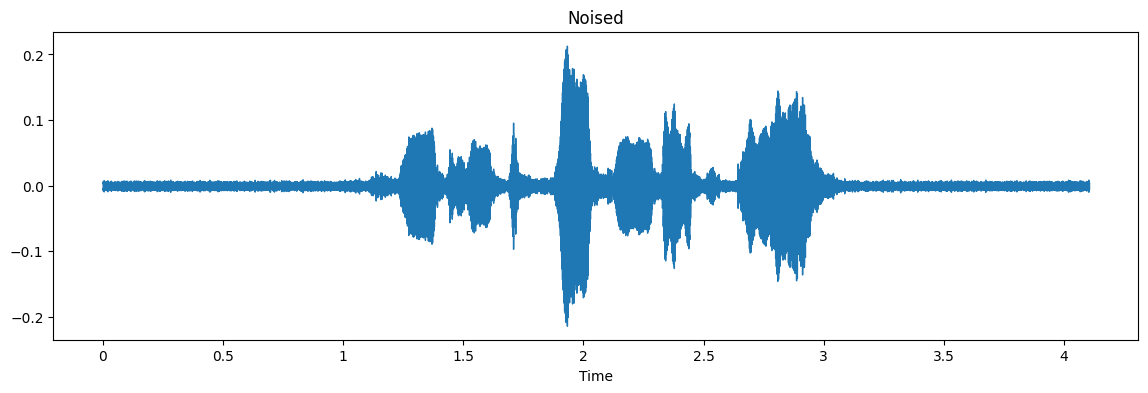

In [ ]:
plt.figure(figsize = (14,4))
librosa.display.waveshow(noised_data, sr = sr)
plt.title('Noised')
Audio(noised_data, rate = sr)

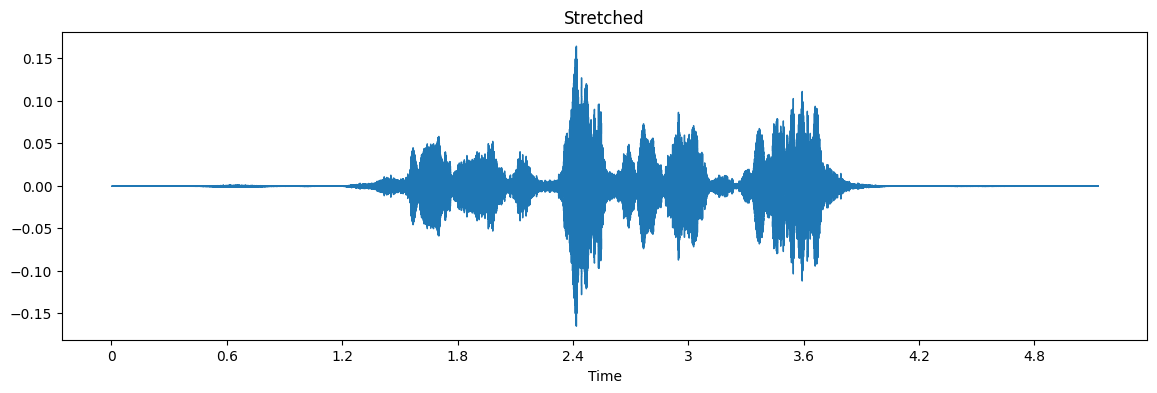

In [ ]:
plt.figure(figsize = (14,4))
librosa.display.waveshow(stretch_data, sr = sr)
plt.title('Stretched')
Audio(stretch_data, rate = sr)

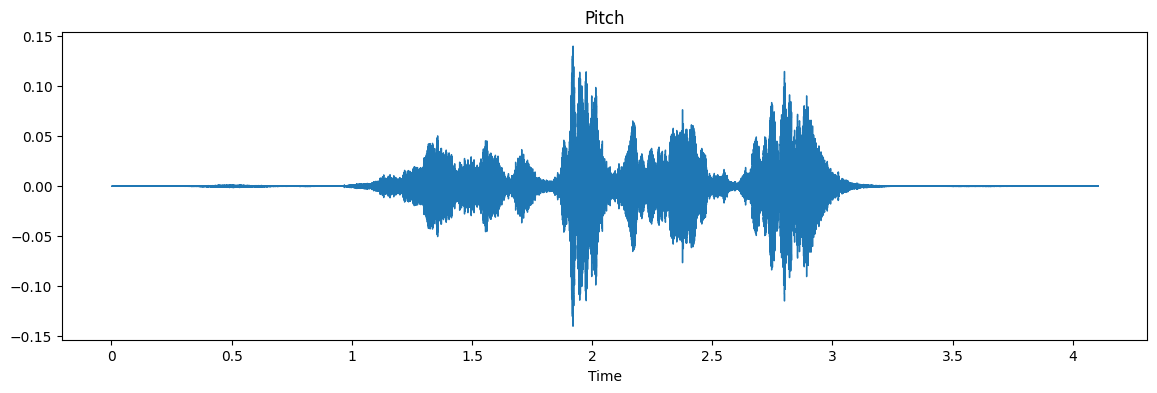

In [ ]:
plt.figure(figsize = (14,4))
librosa.display.waveshow(pitch_data, sr = sr)
plt.title('Pitch')
Audio(pitch_data, rate = sr)

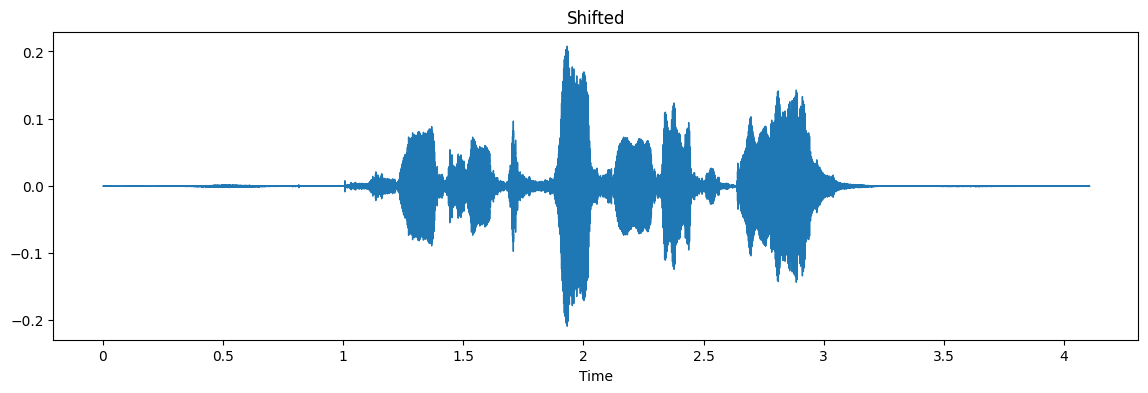

In [ ]:
plt.figure(figsize = (14,4))
librosa.display.waveshow(shift_data, sr = sr)
plt.title('Shifted')
Audio(shift_data, rate = sr)

__Model Building__

__Trying Different Classifiers__

In [ ]:
# Features Extraction
def extract_features(data, sr) :
  result = np.array([])
  # ZCR
  zcr = np.mean(librosa.feature.zero_crossing_rate(data).T, axis = 0)
  result = np.hstack((result, zcr))

  # chroma stft
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr = sr).T, axis = 0)
  result = np.hstack((result, chroma_stft))

  # mfcc
  mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sr).T, axis = 0)
  result = np.hstack((result, mfcc))

  # rms value
  rms = np.mean(librosa.feature.rms(y = data).T, axis = 0)
  result = np.hstack((result, rms))

  # mel spectrogram
  mel = np.mean(librosa.feature.melspectrogram(y = data, sr = sr).T, axis = 0)
  result = np.hstack((result, mel))

  return result

In [ ]:
def get_features(audio) :
  arr, sr = librosa.load(audio, duration = 2.5, offset = 0.6)
  result = np.array(extract_features(arr, sr))

  noisy = noise(arr)
  result = np.vstack((result, extract_features(noisy, sr)))

  pitchy = pitch(stretch(arr), sr)
  result = np.vstack((result, extract_features(pitchy, sr)))

  return result

In [ ]:
get_features(df['path'][1]).shape

(3, 162)

In [ ]:
X, y = [], []
for p, e in zip(df['path'], df['emotion']) :
  f = get_features(p)
  for ele in f :
    X.append(ele)
    y.append(e)
len(X), len(y)

(4320, 4320)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.1, random_state = 11, shuffle = True)
len(xtrain), len(xtest)

(3888, 432)

In [ ]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [ ]:
with open('scaler.pkl', 'wb') as f:
  pickle.dump(scaler, f)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.transform(ytest)

In [ ]:
le.classes_

array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprise'], dtype='<U8')

In [ ]:
def train_pred(models, xtrain, ytrain, xtest, ytest) :
  acc = []
  ypreds = []
  for model in models :
    model.fit(xtrain, ytrain)
    pred = model.predict(xtest)
    acc.append(accuracy_score(ytest, pred))
    ypreds.append(pred)
  return acc, ypreds

In [ ]:
logistic = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()
svc = SVC()
ada = AdaBoostClassifier()

models = [logistic, rf, xgb, svc, ada]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVC', 'AdaBoost']

acc, ypreds = train_pred(models, xtrain, ytrain, xtest, ytest)

In [ ]:
for i in range(len(acc)) :
  print(f"Model : {model_names[i] : <25} Accuracy : {acc[i] : .2%} \n")

Model : Logistic Regression       Accuracy :  52.55% 

Model : Random Forest             Accuracy :  68.06% 

Model : XGBoost                   Accuracy :  78.24% 

Model : SVC                       Accuracy :  53.01% 

Model : AdaBoost                  Accuracy :  30.09% 



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
x = train_pred([KNeighborsClassifier()], xtrain, ytrain, xtest, ytest)
print(f"Model : K Neighbours Classifier {'' : <25} Accuracy : {x[0][0] : .2%}")

Model : K Neighbours Classifier                           Accuracy :  71.30%


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
p = {
    'n_estimators' : [500],
    'max_depth' : [None],
    'min_samples_split' : [100, 150],
    'bootstrap' : [True, False]
}
model = RandomForestClassifier(random_state = 25)
gs = RandomizedSearchCV(estimator = model, n_jobs = -1, cv = 5, param_distributions = p)
gs.fit(xtrain, ytrain)
print(gs.best_params_)
print(gs.best_score_)
print(accuracy_score(ytest, gs.predict(xtest)))

{'n_estimators': 500, 'min_samples_split': 100, 'max_depth': None, 'bootstrap': False}
0.4943520825268897
0.5069444444444444


In [ ]:
from sklearn.ensemble import StackingClassifier
base = [
    ('rf', RandomForestClassifier(random_state = 11)),
    ('xgb', XGBClassifier(random_state = 11)),
    ('knn', KNeighborsClassifier())
]
meta = LogisticRegression()
stack = StackingClassifier(estimators = base, final_estimator = meta, cv = 5, n_jobs = -1)
stack.fit(xtrain, ytrain)
ypred = stack.predict(xtest)
a = accuracy_score(ypred, ytest)
print(f"Model : Stack {'' : <25} Accuracy : {a : .2%} \n")

Model : Stack                           Accuracy :  84.26% 



(432,)

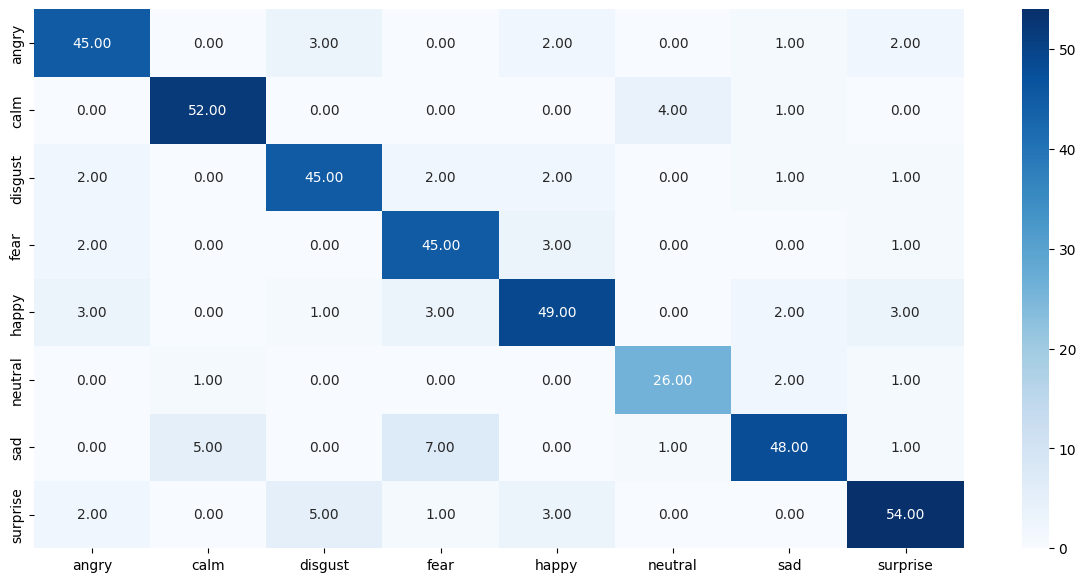

In [ ]:
cm = confusion_matrix(ytest, ypred)
cm = pd.DataFrame(cm, columns = le.classes_, index = le.classes_)
plt.figure(figsize=(15,7))
sns.heatmap(cm, annot = True, fmt = '.2f', cmap = 'Blues')
plt.show()

In [ ]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        53
           1       0.90      0.91      0.90        57
           2       0.83      0.85      0.84        53
           3       0.78      0.88      0.83        51
           4       0.83      0.80      0.82        61
           5       0.84      0.87      0.85        30
           6       0.87      0.77      0.82        62
           7       0.86      0.83      0.84        65

    accuracy                           0.84       432
   macro avg       0.84      0.85      0.84       432
weighted avg       0.84      0.84      0.84       432



In [ ]:
with open('xtrain.pkl', 'wb') as f :
  pickle.dump(xtrain, f)

with open('xtest.pkl', 'wb') as f :
  pickle.dump(xtest, f)

with open('ytrain.pkl', 'wb') as f :
  pickle.dump(ytrain, f)

with open('ytest.pkl', 'wb') as f :
  pickle.dump(ytest, f)

In [ ]:
model_data = {
        'classifier' : stack,
        'label_encoder' : le
    }
with open('stackclassifier.pkl', 'wb') as f :
  pickle.dump(model_data, f)

model_data = {
    'classifier' : xgb,
    'label_encoder' : le
}
with open('xgbclassifier.pkl', 'wb') as f :
  pickle.dump(model_data, f)

In [ ]:
with open('le.pkl', 'wb') as f :
  pickle.dump(le, f)

__Trying Neural Networks (Deep Learning)__

In [ ]:
xtrain = pickle.load(open('xtrain.pkl', 'rb'))
xtest = pickle.load(open('xtest.pkl', 'rb'))
ytrain = pickle.load(open('ytrain.pkl', 'rb'))
ytest = pickle.load(open('ytest.pkl', 'rb'))

In [ ]:
one = OneHotEncoder()
ytrain_encoded = one.fit_transform(ytrain.reshape(-1,1)).toarray()
ytest_encoded = one.transform(ytest.reshape(-1,1)).toarray()

In [ ]:
# Reshape data for lstm (samples, timesteps, features)
def prepare(x, timesteps = 5) :
  x_reshaped = []
  for i in range(len(x) - timesteps + 1) :
    x_reshaped.append(x[i : i + timesteps])
  return np.array(x_reshaped)

In [ ]:
timesteps = 5
xtrain_reshaped = prepare(xtrain)
xtest_reshaped = prepare(xtest)
ytrain_reshaped = ytrain_encoded[timesteps - 1 :]
ytest_reshaped = ytest_encoded[timesteps - 1 :]

In [ ]:
model_lstm = Sequential([
    Bidirectional(LSTM(128, activation = 'relu', return_sequences = True, input_shape = (xtrain_reshaped.shape[1], xtrain_reshaped.shape[2]))),
    BatchNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(64, activation = 'relu')),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(8, activation='softmax')
])

model_lstm.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience = 20, min_delta=0.001, restore_best_weights = True)
rdlr = ReduceLROnPlateau(monitor = 'val_loss', patience = 10, min_lr=0.0001, factor = 0.2, cooldown = 1)

history = model_lstm.fit(xtrain_reshaped, ytrain_reshaped, validation_data = (xtest_reshaped, ytest_reshaped), epochs = 100, batch_size = 32, verbose = 1, callbacks = [es, rdlr])

Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.1427 - loss: 2.5631 - val_accuracy: 0.1636 - val_loss: 2.0975 - learning_rate: 1.0000e-04
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.1743 - loss: 2.3301 - val_accuracy: 0.1869 - val_loss: 2.1479 - learning_rate: 1.0000e-04
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.2232 - loss: 2.1652 - val_accuracy: 0.1916 - val_loss: 2.1781 - learning_rate: 1.0000e-04
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.2632 - loss: 2.0436 - val_accuracy: 0.2243 - val_loss: 2.1797 - learning_rate: 1.0000e-04
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.2770 - loss: 1.9919 - val_accuracy: 0.2477 - val_loss: 2.1536 - learning_rate: 1.0000e-04
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.2738 - loss: 1.9321 - val_accuracy: 0.2617 - val_loss: 2.1529 - learning_rate: 1.0000e-04
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/st

In [ ]:
l , ac = model_lstm.evaluate(xtest_reshaped, ytest_reshaped)
print("Loss: ", l)
print("Accuracy: ", ac)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5362 - loss: 1.4022
Loss:  1.4098261594772339
Accuracy:  0.5350467562675476


In [ ]:
yp = model_lstm.predict(xtest_reshaped)
yp = np.argmax(yp, axis = 1)
true = np.argmax(ytest_reshaped, axis = 1)
print(classification_report(true, yp))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
              precision    recall  f1-score   support

           0       0.65      0.66      0.65        53
           1       0.66      0.65      0.65        57
           2       0.41      0.46      0.43        52
           3       0.45      0.58      0.50        50
           4       0.50      0.43      0.46        61
           5       0.35      0.31      0.33        29
           6       0.51      0.45      0.48        62
           7       0.67      0.64      0.66        64

    accuracy                           0.54       428
   macro avg       0.52      0.52      0.52       428
weighted avg       0.54      0.54      0.53       428



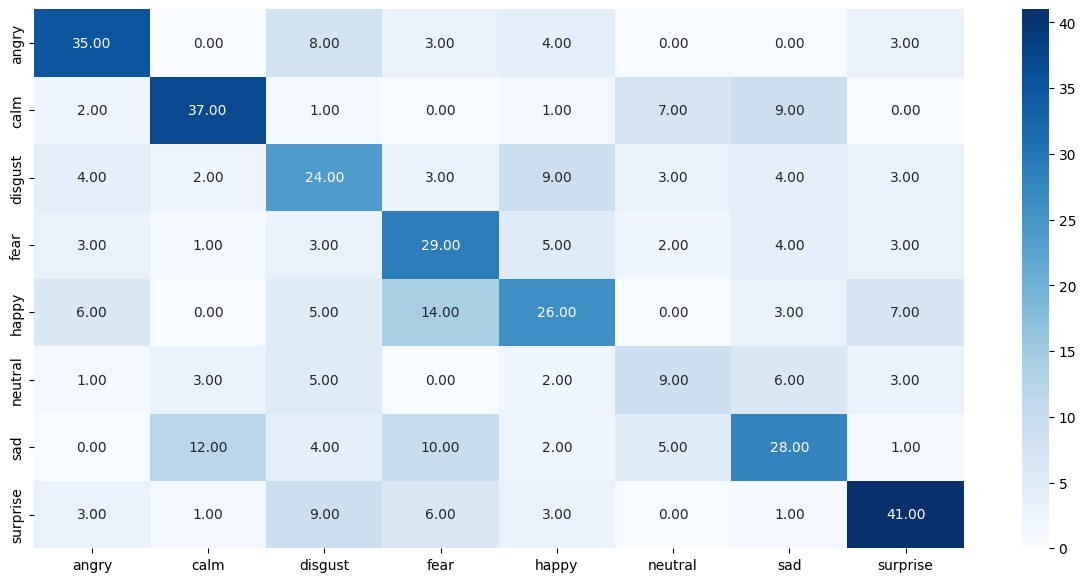

In [ ]:
cm = confusion_matrix(true, yp)
d = pd.DataFrame(cm, columns = le.classes_, index = le.classes_)
plt.figure(figsize=(15,7))
sns.heatmap(d, annot = True, fmt = '.2f', cmap = 'Blues')
plt.show()

In [ ]:
with open('lstm.pkl', 'wb') as f :
  pickle.dump(model_lstm, f)

In [ ]:
model_lstm.save('lstm_speech.h5')  # Recommended format for Keras models

In [ ]:
q = np.random.rand(1, 6, 512).astype(np.float32)
q.shape

(1, 6, 512)